In [16]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy import stats
import statsmodels.api as sm

#Установка аспектов визуальной темы для всех графиков matplotlib и seaborn.\
    # Эта функция изменяет глобальные настройки по умолчанию для всех графиков, использующих систему rcParams matplotlib. Тематика разлагается на несколько отдельных наборов значений параметров
    
sns.set_theme( rc={'figure.figsize': (9, 6)}) 

In [17]:
data_Yiar=pd.read_csv('CSV_EXCEL\\Погода_2024.csv', delimiter=';')

# Формируем датасет data_Yiar согласно индексам data_549 (не учитывая выходные дни)

res_Date = []

for i in data_Yiar.Date[:]:  
    res_Date.append(datetime.strptime(i,'%d.%m.%Y').date())

data_Yiar['Date'] = pd.Series(res_Date)     

'''Полезные приёмы при работе с Pandas:

data_Yiar.describe(include='all')
data_Yiar.loc[['27.12.2024','30.12.2024']]
data_Yiar.loc[data_Yiar.night_temperature > 0, :]
data_Yiar.query('night_temperature > 0'); data_Yiar[data_Yiar.night_temperature > 0]
data_Yiar.night_temperature.unique()
data_Yiar = data_Yiar.set_index(data_Yiar.Date).drop(['Date'],axis=1)
data_Yiar.set_index(data_Yiar.Date)'''

data_Yiar

,Date,day_temperature,night_temperature
0,2024-02-01,1,-2
1,2024-02-02,1,-4
2,2024-02-03,-4,-8
3,2024-02-04,-5,-8
4,2024-02-05,-3,-8
...,...,...,...
330,2024-12-27,2,-8
331,2024-12-28,-2,-9
332,2024-12-29,1,-3
333,2024-12-30,2,1


In [18]:
# Собираем датасет data_549

data_549=pd.read_csv('CSV_EXCEL\\климатика_2024_549.csv', delimiter=';')

res = pd.Series([float(i.replace(',','.')) for i in data_549.temperature_549]) # Конвертируем тип данных str в тип данных float

data_549 = pd.DataFrame({'Date': [datetime.strptime(i,'%d.%m.%Y').date() for i in data_549.Date],
                         'temperature_549': res,
                         'humidity_549': data_549.humidity_549})

data_549


,Date,temperature_549,humidity_549
0,2024-02-02,22.0,23
1,2024-02-05,21.4,23
2,2024-02-05,21.4,23
3,2024-02-06,21.1,23
4,2024-02-06,21.0,23
...,...,...,...
452,2024-12-18,22.1,22
453,2024-12-19,21.7,21
454,2024-12-19,21.9,22
455,2024-12-20,22.0,22


In [19]:
# Формируем единый датасет
data_549 = data_Yiar.merge(data_549, how='inner')  # Объеденяем датафреймы c пересечением (без пересечения используем аргумент how='outer')

data_549['Month'] = [i.month for i in data_549.Date]

data_549

,Date,day_temperature,night_temperature,temperature_549,humidity_549,Month
0,2024-02-02,1,-4,22.0,23,2
1,2024-02-05,-3,-8,21.4,23,2
2,2024-02-05,-3,-8,21.4,23,2
3,2024-02-06,-8,-15,21.1,23,2
4,2024-02-06,-8,-15,21.0,23,2
...,...,...,...,...,...,...
452,2024-12-18,-10,-15,22.1,22,12
453,2024-12-19,-9,-22,21.7,21,12
454,2024-12-19,-9,-22,21.9,22,12
455,2024-12-20,2,-9,22.0,22,12


<Axes: title={'center': 'temperature_549'}, xlabel='Month'>

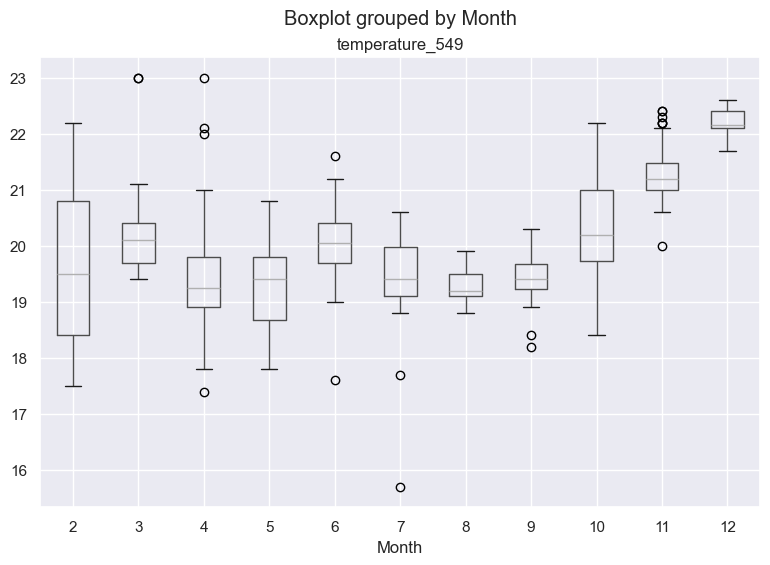

In [20]:
data_549.boxplot(by='Month', column='temperature_549')  # Box plot харектиризующий изменчивость признака в разные месяцы

<Axes: title={'center': 'humidity_549'}, xlabel='Month'>

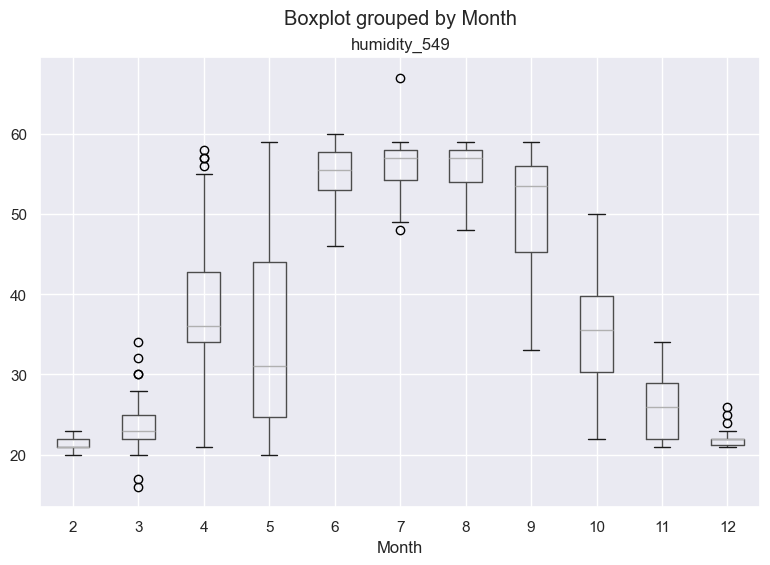

In [21]:
'''Данные графики типа Box plot дают основания пологать, что распределение вероятн6остей данного признака
не постоянно, а значит система HVAC находится в неконтролируемом состоянии и требуется настройка (колибровка)'''

data_549.boxplot(by='Month', column='humidity_549')  # Box plot харектиризующий изменчивость признака (распределение вероятностей) в разные месяцы

In [22]:
data_549_mean = data_549[['humidity_549','temperature_549','Month','night_temperature','day_temperature']].groupby(['Month']).mean() # Датафрейм со средними значениями

data_549_mean

,humidity_549,temperature_549,night_temperature,day_temperature
Month,,,,
2,21.268293,19.621951,-13.853659,-6.853659
3,23.795455,20.225000,-5.545455,1.681818
4,38.595238,19.421429,4.761905,13.238095
5,34.775000,19.290000,4.650000,16.350000
6,55.105263,19.992105,12.894737,22.157895
7,56.369565,19.434783,14.565217,25.347826
8,55.934783,19.276087,12.000000,21.956522
9,50.071429,19.409524,10.523810,21.619048
10,34.673913,20.252174,3.434783,9.304348


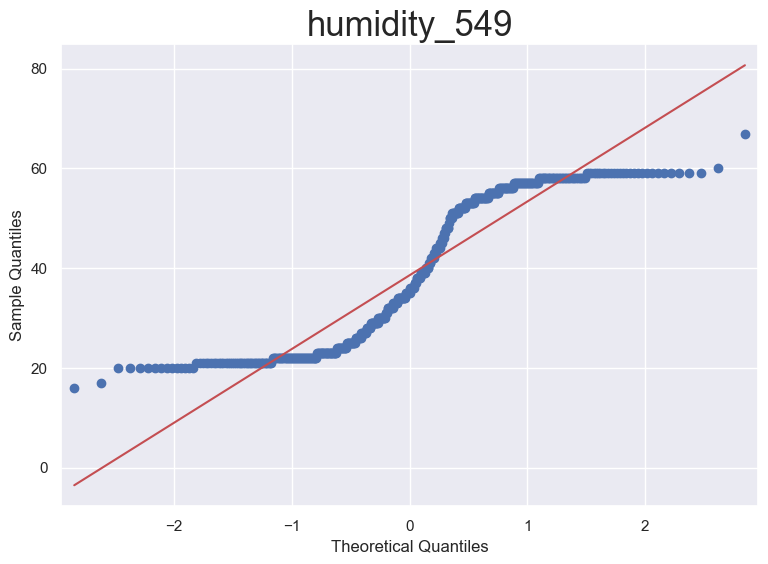

In [23]:
# создаем QQ-plot с помощью statsmodels, в качестве аргумента 'humidity_549' из отсортированного датасета

sm.qqplot(data_549['humidity_549'], line='s')

# добавляем название графика

plt.title('humidity_549', fontsize=25)

# выводим на экран 

plt.show()

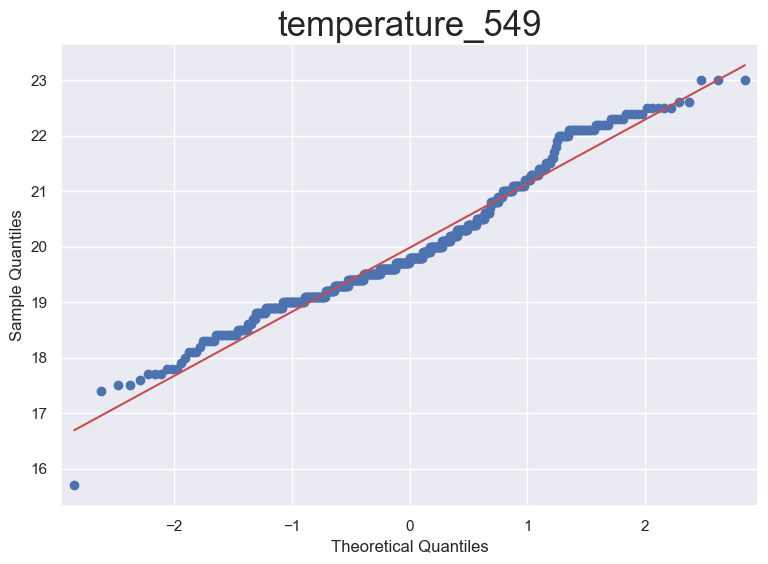

In [24]:
# создаем QQ-plot с помощью statsmodels, в качестве аргумента 'temperature_549' из отсортированного датасета

sm.qqplot(data_549['temperature_549'], line='s')

# добавляем название графика

plt.title('temperature_549', fontsize=25)

# выводим на экран 

plt.show()

Data means are not normally distributed. Can't use t-test
0.8588957378360975 7.317559355024277e-20


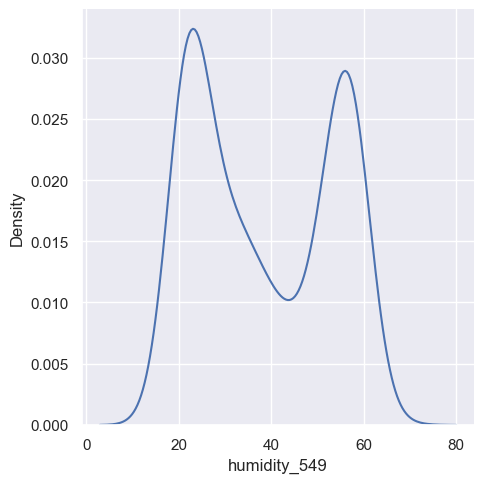

In [47]:
# Плотность распределения для оценки нормальности распределения. Наше распределение нормальным не назавёшь. Нет возможности использовать т-распределение. Используем U критерий

stats_ = stats.shapiro(data_549['humidity_549'])

if stats_.pvalue < 0.05:
    print("Data means are not normally distributed. Can't use t-test")
    print(stats_.statistic, stats_.pvalue)
else:
    print("Data means are normally distributed. t-test ok")    

sns.displot(data_549.humidity_549, kind='kde')



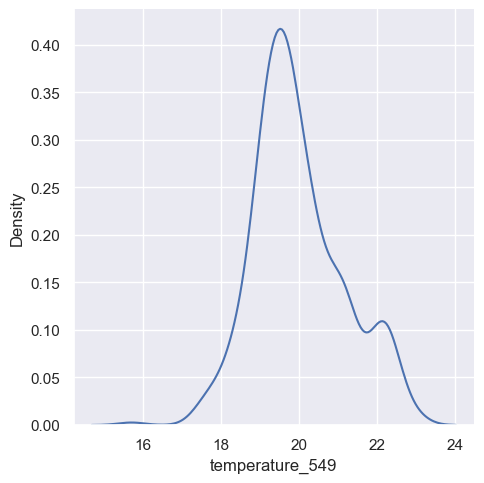

In [26]:
# Плотность распределения для оценки нормальности распределения. 

sns.displot(data_549.temperature_549, kind='kde')

In [27]:
# plt.plot(x1, linear_1(x1))

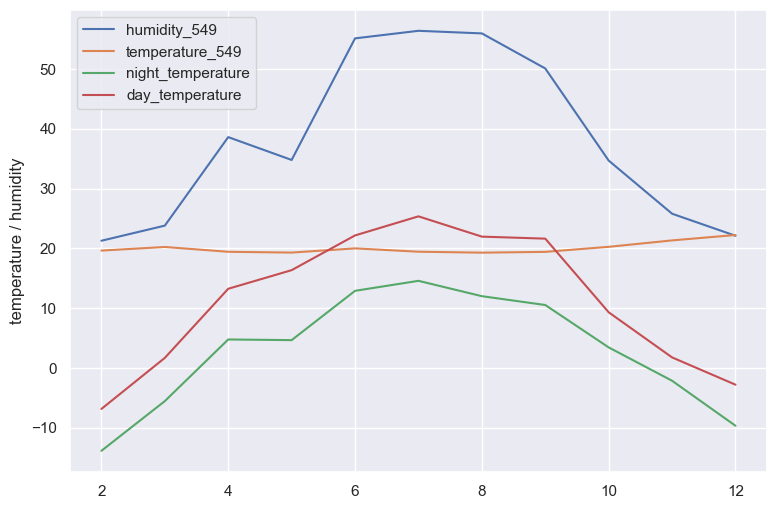

In [28]:
plt.plot(data_549_mean) # Построим простой график температур
plt.ylabel('temperature / humidity')
plt.legend(['humidity_549', 'temperature_549', 'night_temperature', 'day_temperature'], loc='upper left')
# plt.errorbar(x=[2.4, 4.4], y=means[2:], yerr=sems[2:],
#             capsize=3, marker='s', color='brown')
plt.show()

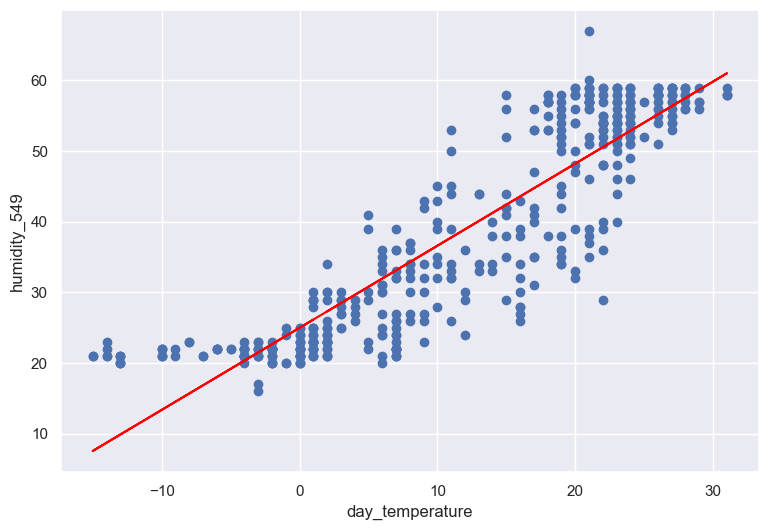

'y = 25.0007416758359 + 1.1613355253680555 * x'

In [29]:
# sns.lmplot(x='day_temperature', y='humidity_549', data=data_549,) 

# Построили диаграмму рассеивания влажности в помещении в зависимости от средней температуры в районе
x = np.array(list(data_549['day_temperature']))
y = np.array(list(data_549['humidity_549']))

plt.scatter(x, y)
b1, b0 = np.polyfit(x, y, 1) #  b0 - intercept, b1 - slope
plt.plot(x, b0 + b1*x, color='red')
plt.xlabel('day_temperature')
plt.ylabel('humidity_549')
plt.show()
f'y = {b0} {'+' if b1 >= 0 else '-'} {abs(b1)} * x'


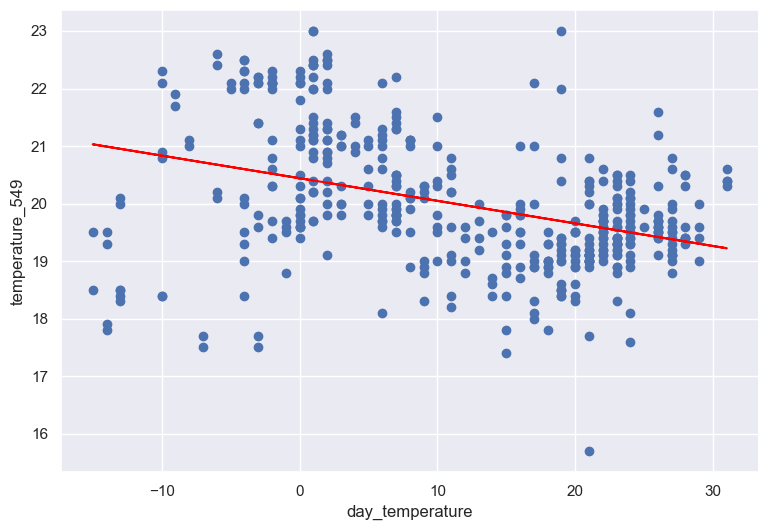

'y = 20.440780162678944 - 0.03928119213470685 * x'

In [30]:
# sns.scatterplot(x='day_temperature', y='temperature_549', data=data_549) # Построили диаграмму рассеивания температуры в помещении в зависимости от средней температуры в районе
# Возможно мы наблюдаем обратную взаимосвязь
# Возможно нарушенно условие применения регресионного анализа, а именно нормальность распределения остатков или гомоскедастичность

x = np.array(list(data_549['day_temperature']))
y = np.array(list(data_549['temperature_549']))

plt.scatter(x, y)
b1, b0 = np.polyfit(x, y, 1) #  b0 - intercept, b1 - slope
plt.plot(x, b0 + b1*x, color='red')
plt.xlabel('day_temperature')
plt.ylabel('temperature_549')
plt.show()
f'y = {b0} {'+' if b1 >= 0 else '-'} {abs(b1)} * x'

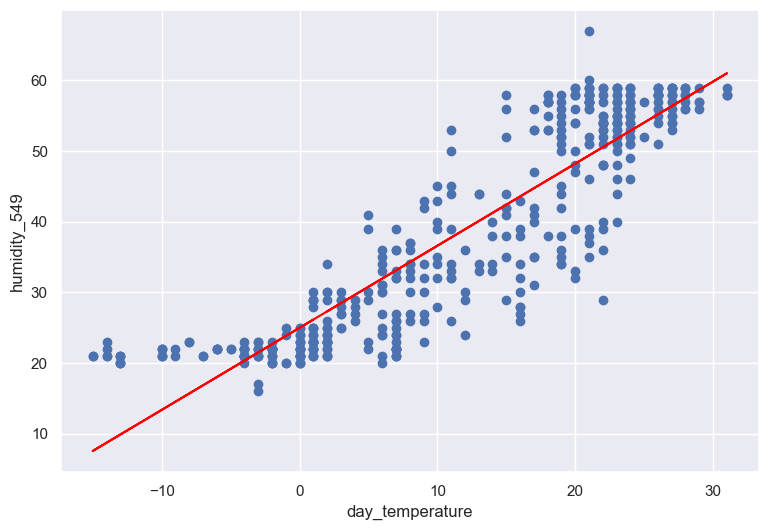

'y = 25.0007416758359 + 1.1613355253680555 * x'

In [31]:
x = np.array(list(data_549['day_temperature']))
y = np.array(list(data_549['humidity_549']))

plt.scatter(x, y)
b1, b0 = np.polyfit(x, y, 1) #  b0 - intercept, b1 - slope
plt.plot(x, b0 + b1*x, color='red')
plt.xlabel('day_temperature')
plt.ylabel('humidity_549')
plt.show()
f'y = {b0} {'+' if b1 >= 0 else '-'} {abs(b1)} * x'

In [32]:
data_549[['humidity_549', 'temperature_549', 'night_temperature', 'day_temperature']].corr('pearson')



,humidity_549,temperature_549,night_temperature,day_temperature
humidity_549,1.000000,-0.424616,0.877223,0.896990
temperature_549,-0.424616,1.000000,-0.302836,-0.388425
night_temperature,0.877223,-0.302836,1.000000,0.952923
day_temperature,0.896990,-0.388425,0.952923,1.000000


In [33]:
data_549[['humidity_549', 'temperature_549', 'night_temperature', 'day_temperature']].corr('spearman')  
# В следствие того, что зависимая переменная humidity имеет ненормальных харрактер распределения, имеет смысл попытаться применить не параметрический критериий корриляции Спирмена

,humidity_549,temperature_549,night_temperature,day_temperature
humidity_549,1.000000,-0.382602,0.934416,0.898388
temperature_549,-0.382602,1.000000,-0.346623,-0.372890
night_temperature,0.934416,-0.346623,1.000000,0.958677
day_temperature,0.898388,-0.372890,0.958677,1.000000


alpha: 0.05 %
corr: 0.8970
R-squared: 0.8046
b0: 25.000741675835886 b1: 1.161335525368057
y = 25.00 + 1.16 * x


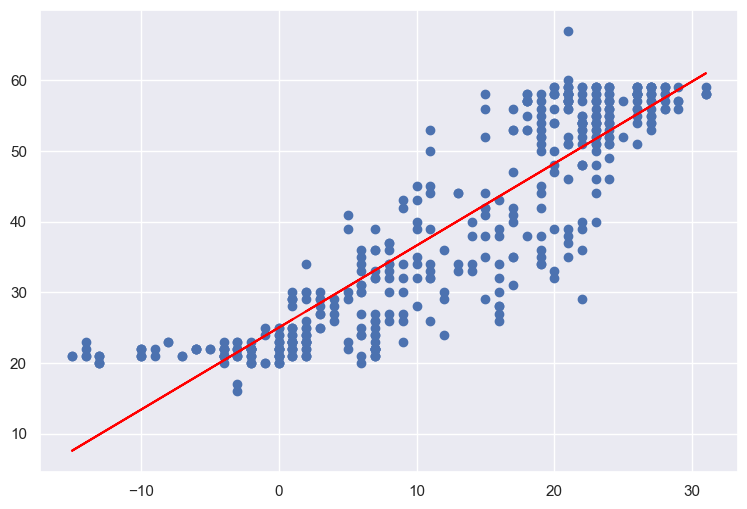

se:  0.026831059523250857
p_value: 0.0
p_value(X < 43.28 or X > 43.28) < alpha. Reject H0

statsmodels:                              OLS Regression Results                            
Dep. Variable:           humidity_549   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1873.
Date:                Mon, 06 Jan 2025   Prob (F-statistic):          2.04e-163
Time:                        22:47:27   Log-Likelihood:                -1506.1
No. Observations:                 457   AIC:                             3016.
Df Residuals:                     455   BIC:                             3024.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [34]:
# Проверим статистичекую гипотизу о значимости взаимосвязи

X = data_549['day_temperature']
Y = data_549['humidity_549']
 
plt.scatter(X, Y)

# H0: b1 = 0
# H1: b1 != 0

alpha = 0.05
df = len(Y) - 2

print(f'alpha: {alpha} %')
 
X_mean = np.mean(X)
Y_mean = np.mean(Y)

corr = np.sum((X - X_mean) * (Y - Y_mean)) / (np.sum((X - X_mean) ** 2) * np.sum((Y - Y_mean) ** 2)) ** 0.5

print('corr: %.4f'  %(corr))
print('R-squared: %.4f'  %(corr ** 2))

X_sd = np.std(X)
Y_sd = np.std(Y)

b1 = (Y_sd / X_sd) * corr
b0 = Y_mean - b1 * X_mean

print('b0:', b0, 'b1:', b1)
print(f'y = {b0:.2f} {'+' if b1 >= 0 else '-'} {abs(b1):.2f} * x')

plt.plot(X, b0 + b1 * X, color='red')
plt.show()

s2 = np.sum((Y - (b0 + b1 * X)) ** 2) / (df) # оценка дисперсии остатков
se = (s2 / (sum((X - X_mean) ** 2))) ** 0.5

print('se: ', se)

t_value = b1 / se
p_value = 2 * (1 - stats.t.cdf(abs(t_value), df))

print('p_value:', p_value)

if p_value > alpha:
    print(f'p_value(X < {t_value:.2f} or X > {t_value:.2f}) > alpha. Do not reject H0')
else:
    print(f'p_value(X < {t_value:.2f} or X > {t_value:.2f}) < alpha. Reject H0')

X2 = sm.add_constant(X)

model = sm.OLS(Y, X2) 
results = model.fit()

print()
print('statsmodels: ', results.summary())

# Вывод: практически 80% изменчивости нашей зависимой переменной объясняется нашей моделью (фактором day_temperature)
#        И только 20% обусловленны другими (неизвестными) факторами.

# F-анализ показал, что наша модель адекватна

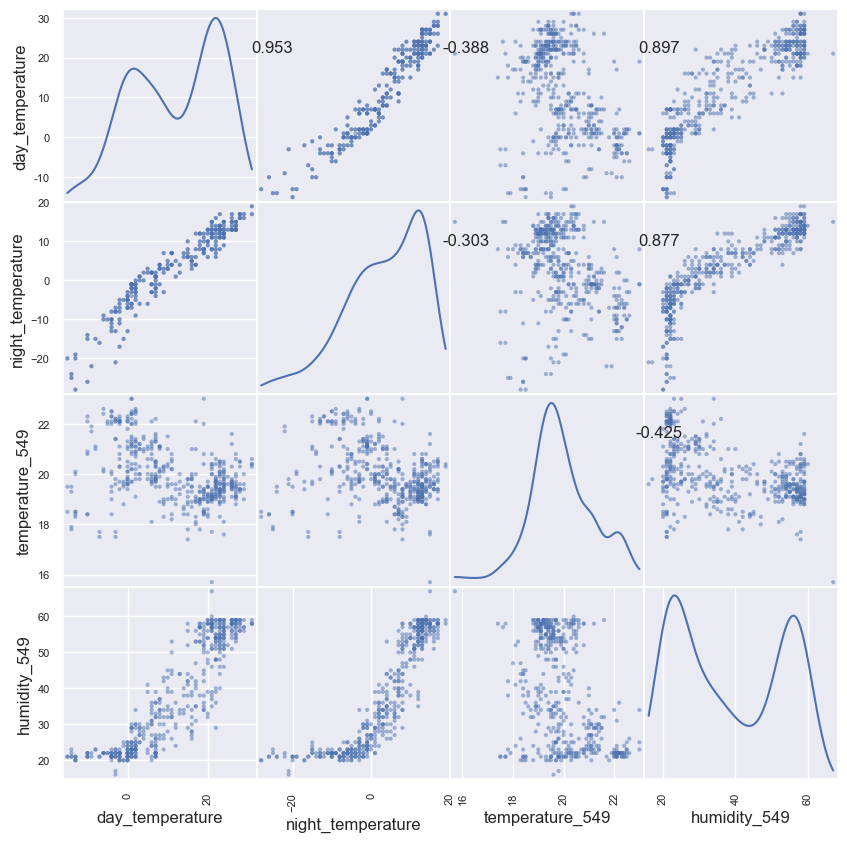

In [35]:
# Диаграммы рассеивания, описывающие характер взаимосвязи количественных переменных. Сила взаимосвязи переменных.

axes = pd.plotting.scatter_matrix(data_549.drop(['Month',"Date"],axis=1), figsize=(10,10), diagonal='kde', grid=True)
corr = data_549.drop(['Month',"Date"],axis=1).corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.08, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

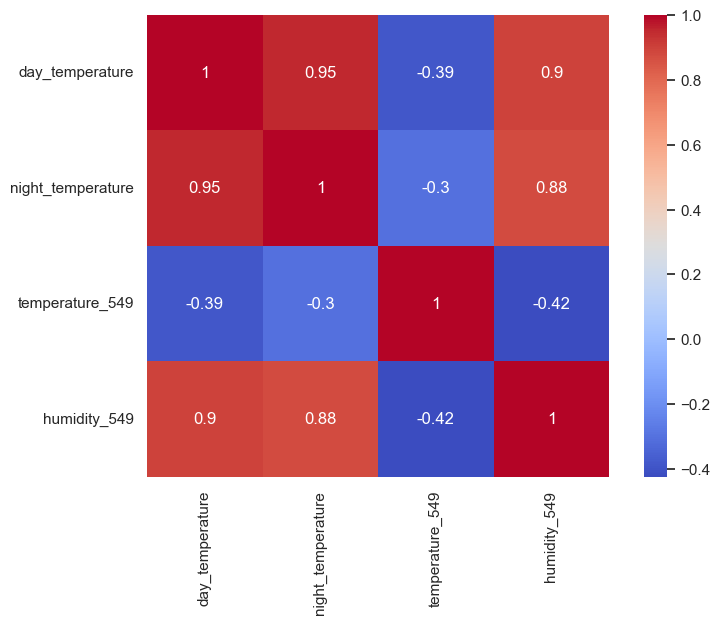

In [36]:
# Оцениваем взаимосвязь факторов между собой

features = data_549.drop(['Month',"Date"],axis=1).columns
f,ax = plt.subplots(1,1)
sns.heatmap(data_549.drop(['Month',"Date"],axis=1)[features].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()
plt.close()

statsmodels:                              OLS Regression Results                            
Dep. Variable:           humidity_549   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     100.1
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           1.98e-21
Time:                        22:47:28   Log-Likelihood:                -1833.7
No. Observations:                 457   AIC:                             3671.
Df Residuals:                     455   BIC:                             3680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             147.2087  

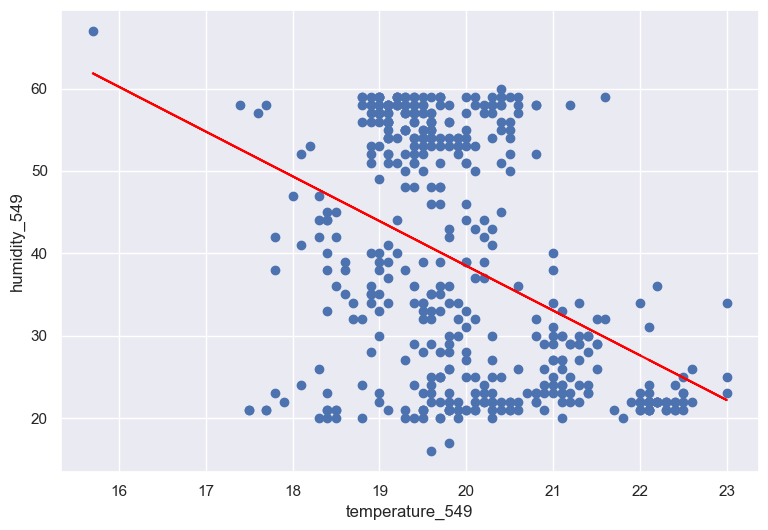

'y = 147.2086912280187 - 5.436118436516241 * x'

In [37]:
#  Кореляция между переменными temperature_549 и humidity_549.

model = sm.OLS(data_549.humidity_549, sm.add_constant(data_549[['temperature_549']])) 
results = model.fit()

print('statsmodels: ', results.summary())
print()
x = np.array(list(data_549['temperature_549']))
y = np.array(list(data_549['humidity_549']))

plt.scatter(x, y)
b1, b0 = np.polyfit(x, y, 1) #  b0 - intercept, b1 - slope
plt.plot(x, b0 + b1*x, color='red')
plt.xlabel('temperature_549')
plt.ylabel('humidity_549')
plt.show()
f'y = {b0} {'+' if b1 >= 0 else '-'} {abs(b1)} * x'

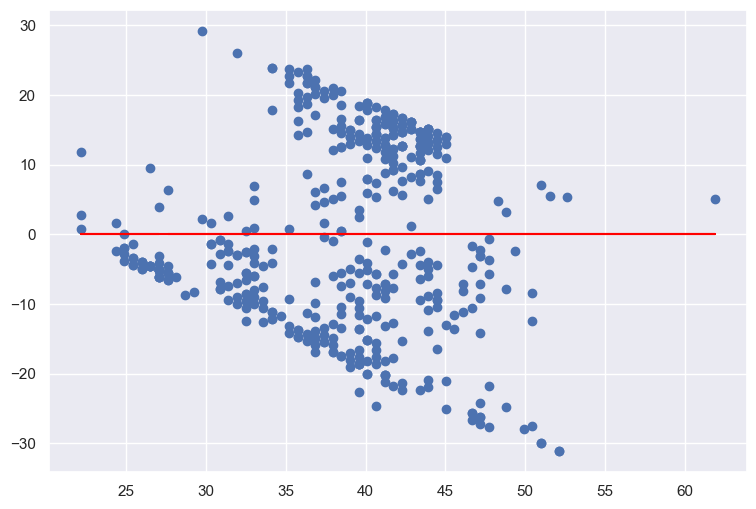

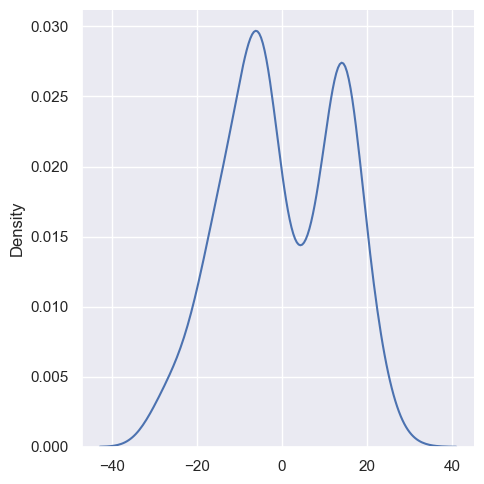

In [38]:
#  Кореляция между переменными temperature_549 и humidity_549 обратная, адекватная, коэффициент детерминации 0,18. Взаимосвязь значимая.
#  Но остатки полученные на основании регресионной мадели не гомоскедастичны

SSres = pd.Series([Y - (147.2087 - 5.4361 * X) for Y, X in zip(tuple(data_549.humidity_549), tuple(data_549.temperature_549))])

Values = pd.Series([(147.2087 - 5.4361 * X) for Y, X in zip(tuple(data_549.humidity_549), tuple(data_549.temperature_549))])

plt.scatter(y = SSres, x = Values)
plt.plot(Values, [0] * len(Values), color='red')
plt.show()

sns.displot(SSres, kind='kde')